In [23]:
#!/bin/python3

# WARNING: you need ffprobe to gather statistics about videos

import pandas as pd
import numpy as np
import os
import re

# for checking video location in xiph repo
from lxml import html
import requests

import matplotlib.pyplot as plt
import subprocess
from scipy import stats

# needed for ffprobe
import json
from IPython.display import display, HTML

folder = "/Users/macher1/Documents/SANDBOX/x264-backup/x264-benchmarks/wasm"
pathVideos="/Volumes/LaCie/x264Videos" #"/Users/macher1/Downloads/x264-videos"

rSize = pd.DataFrame(columns=["dirname", "video", "format", "cluster", "size", "duration", "bit_rate", "width", "height",
                              'r_frame_rate', 'abbrsize', 'nbrepl'])
rTime = pd.DataFrame(columns=["dirname", "video", "format", "cluster", "size", "duration", "bit_rate", "width", "height",
                              'r_frame_rate', 'abbrsize', 'nbrepl'])

for dirname in os.listdir(folder):
    pathdir = os.path.join(folder, dirname)
    if os.path.isdir(pathdir) and (dirname != "tmp" and dirname != "x264-0608-coastmp4-wasm-merged"):     
        for linev in open(os.path.join(pathdir, "launchAll"), 'r'):
            matchv = re.search('echo "Copying video: "(.*)', linev)
            if matchv:
                video=matchv.group(1).strip()
                if video.endswith('y4m'):
                    for line in open(os.path.join(pathdir, "x264-igrida"), 'r'):
                        match = re.search('#OAR -p cluster =(.*)', line)
                        if match:
                            cluster=match.group(1).strip()
                            rSize = rSize.append({"dirname": dirname, "video": video, "format": "y4m", "cluster": cluster}, 
                                        ignore_index=True)
                            if cluster == "'calda'":
                                rTime = rTime.append({"dirname": dirname, "video": video, "format": "y4m", "cluster": cluster}, 
                                        ignore_index=True)

frSize = rSize.drop(rSize[(rSize['dirname'] == "x264-0308-sintel-wasm") | (rSize['dirname'] == "x264-0408-tos3k-wasm") | (rSize['dirname'] == "x264-0208-crowd_run-bermuda-wasm") | (rSize['dirname'] == "x264-0408-football-wasm")].index)

assert(len(frSize) == 25)

frTime = rTime.drop(rTime[(rTime['dirname'] == "x264-0308-sintel-wasm") | (rTime['dirname'] == "x264-0408-tos3k-wasm")].index)
assert(len(frTime) == 17)

## checking whether videos are present in media.xiph.org
CHECKING=False
if (CHECKING):
    page = requests.get('https://media.xiph.org/video/derf/y4m/')
    for v in frSize['video']:
        if (v not in page.text):
            print("Unfound " + v)

    for v in frTime['video']:
        if (v not in page.text):
            print("Unfound " + v)



def alignDataset(sizeAlignment, timeAlignment):
    
    common = []
    for i, s in sizeAlignment.iterrows(): 
        vs = s['dirname'] #.values
        #for v in vs:
        if vs in timeAlignment['dirname'].values:
             common.append(s)
    
    specificSize = []
    for i, s in sizeAlignment.iterrows(): 
        vs = s['dirname']# .values
        #for v in vs:
        if vs not in timeAlignment['dirname'].values:
            specificSize.append(s)

    specificTime = []
    for t in timeAlignment: 
        vt = timeAlignment['dirname'].values
        for v in vt:
            if v not in sizeAlignment['dirname'].values:
                specificTime.append(t)
                
    
    # time datas are subsets of size datas
    assert(len(specificSize) + len(common) == len(sizeAlignment))
    assert (len(specificTime) == 0)
    
    common = pd.DataFrame(common)
    common = common.sort_values(by="dirname")
    specificSize = pd.DataFrame(specificSize)
    specificSize = specificSize.sort_values(by="dirname")
    specificTime = pd.DataFrame(specificTime)    
  
    return pd.DataFrame(common.append(specificSize)), pd.DataFrame(common.append(specificTime))

#frSize, frTime = alignDataset(frSize, frTime)


def getVideoStat(filename):
    process = subprocess.Popen(['/usr/local/bin/ffprobe', '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams', '-i', str(filename)], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()
    vStatJson = json.loads(stdout)
    vStatFormat = vStatJson['format'] 
    nbStreams = int(vStatFormat["nb_streams"])
    if (nbStreams != 1):
        print("More than one stream in the video!")
        return 
    vStatStream = vStatJson['streams'][0] # TODO: we assume only one stream per video
    return (vStatFormat, vStatStream) 

# size in Megabytes
# assume "filename" exists
def getFileSize(filename): 
    vStatInfo = os.stat(filename)
    return vStatInfo.st_size / (1024*1024.0) # in Megabytes


def computeAbrSize(width, height):
    if (width == 176) and (height == 144):
        return "qcif"
    elif (width == 352) and (height == 288):
        return "cif"
    elif (width == 704) and (height == 576):
        return "4cif"
    elif (width == 1920) and (height == 1080):
        return "hd1080"
    elif (width == 352) and (height == 240):
        return "qntsc"
    elif (width == 1280) and (height == 720):
        return "hd720"    
    # normally ‘hd480’ 852x480 (small hack for sintel)
    elif (width == 852 or width == 854) and (height == 480):
        return "hd480"   
    elif (width == 4096) and (height == 2160):
        return "4k"  
    else:
        return "other"

def fillVideoMetaInformation(data):       
    for i, r in data.iterrows(): 
        v = r['video'] 
        fullFileName = os.path.join(pathVideos, v)
        if (not os.path.isfile(fullFileName)):  
            # r['field_order'] =  r["pix_fmt"] =
            r['size'] = r['duration'] = r['bit_rate'] = r['width'] = r['height'] = r['r_frame_rate'] = r['abbrsize'] = -1
            # r['chroma_location'] = 
        else:
            vsize = getFileSize(fullFileName)
            vStatVideo, vStatStream  = getVideoStat(fullFileName)
             # stock values in a dataframe
            r['size'] = vsize
            r['duration'] = float(vStatVideo['duration'])
            r['bit_rate'] = float(vStatVideo['bit_rate'])
            r['width'] = int(vStatStream['width'])
            r['height'] = int(vStatStream['height'])
        #    r['chroma_location'] = vStatStream['chroma_location']
            #r['field_order'] = vStatStream['field_order']
            r['r_frame_rate'] = vStatStream['r_frame_rate']
            # https://www.ffmpeg.org/ffprobe-all.html
            r['abbrsize'] = computeAbrSize(r['width'], r['height']) 
        #   r["pix_fmt"] = vStatStream["pix_fmt"] 
    #print(frTime[frTime['video'] == v])
    #print(str(v) + " " + str(vstats))
        
        
#frTime
fillVideoMetaInformation(frSize)
# fillVideoMetaInformation(frTime)

def hasAllConfigurationMeasurements(pathdir, csv_file):
    csv = pd.read_csv(open(os.path.join(pathdir, csv_file), "r"))
    return len(csv) == 1152

### how many times we have replicated experiments per video 
def fillNbReplication(data):
    for i, r in data.iterrows():
            dirname = r['dirname']
            pathdir = os.path.join(folder, dirname)
            if os.path.isdir(pathdir) and (dirname != "tmp" and dirname != "x264-0608-coastmp4-wasm-merged"):
                # number of replication is number of CSV files 
                files = os.listdir(pathdir)
                csv_files = [f for f in files if f.endswith('.csv') and f.startswith('x264-results') and hasAllConfigurationMeasurements(pathdir, f)]
                # csv_files.filter()
                
                nbreplication = len(csv_files)
                
                r['nbrepl'] = nbreplication  

fillNbReplication(frSize)
fillNbReplication(frTime)

frSize, frTime = alignDataset(frSize, frTime)

#plt.figure()
#frSize['size'].plot.box()   
#plt.show()

#display(HTML(frSize.drop(['cluster', 'dirname', 'format'], axis=1).reset_index(drop = True).to_html()))
#display(HTML(frTime.drop(['cluster', 'dirname', 'format'], axis=1).reset_index(drop = True).to_html()))
#frTime.drop(['cluster', 'dirname', 'format'], axis=1).reset_index(drop = True) #.to_latex())

print (frSize.drop(['cluster', 'dirname', 'format'], axis=1).reset_index(drop = True).to_latex())


# frSize

def sanityReplication(data, pred):
    for i, r in data.iterrows():
            dirname = r['dirname']
            pathdir = os.path.join(folder, dirname)
            files = os.listdir(pathdir)
            csv_files = [f for f in files if f.endswith('.csv') and f.startswith('x264-results')]
            csv_files.sort()
            measures = []
            for csv_file in csv_files:
                csv = pd.read_csv(open(os.path.join(pathdir, csv_file), "r"))
                measures.append(csv[pred])            
            columnPred = [] 
            for m in range(len(measures)):
                columnPred.append(pred + "_" + str(m)) 
            pmeasures = pd.DataFrame(measures)#.transpose()
            pmeasures.index=columnPred
            #pmeasures = pmeasures.transpose()
            #print("######### " + str(i))
            corrs = [[np.NaN for x in range(len(measures))] for y in range(len(measures))]
            for m in range(len(measures)):
                 for n in range(m, len(measures)):
                    #return
                    #corr = np.corrcoef(pmeasures.iloc[m], pmeasures.iloc[n])[0,1] 

                    #isCorrelable = True # not (pmeasures.iloc[m].isnull().values.any() and pmeasures.iloc[n].isnull().values.any())
                                        # True

                    #for e in pmeasures.iloc[n]:
                    #    if (pd.isna(e)):
                    #        isCorrelable = False
                            #print("Aie " + str(n) + " " + dirname)
                    #        break
                    #for e in pmeasures.iloc[m]:
                    #    if (pd.isna(e)):
                    #        isCorrelable = False
                            #print("Aie " + str(m) + " " + dirname)
                    #        break
                    #if (isCorrelable):
                    corr = stats.spearmanr(pmeasures.iloc[m], pmeasures.iloc[n]).correlation
                    corrs[n][m] = corr
                    #else:
                    #    corrs[n][m] = -1
                        #print("Correlation_" + str(dirname) + " " + str(m) + " and " + str(n) + " => " + str(corr)) 
                        
                        #if (corr != 1.0):
                        #    print(pd.DataFrame(pmeasures.iloc[m]).describe())
                        #    print(pd.DataFrame(pmeasures.iloc[n]).describe())
            display(HTML("<h1>" + dirname + " </h1>" + pd.DataFrame(corrs).to_html()))
            print(pd.DataFrame(corrs)[0].min(skipna=True))
                                               
            #
            #display(HTML(pmeasures.transpose()[:10].to_html()))

#sanityReplication(frSize, "size")
#sanityReplication(frTime, "elapsedtime")
               


def meanPerVideo(data, pred, outputCSVdir):
    for i, r in data.iterrows():
            dirname = r['dirname']
            pathdir = os.path.join(folder, dirname)
            files = os.listdir(pathdir)
            csv_files = [f for f in files if f.endswith('.csv') and f.startswith('x264-results')]
            csv_files.sort()
            measures = []
            fcsv = pd.DataFrame()
            firstTime = True
            c = 1
            meanPred = pd.DataFrame()
            meanPredusertime = pd.DataFrame()
            meanPredsystemtime = pd.DataFrame()
            for csv_file in csv_files:
                csv = pd.read_csv(open(os.path.join(pathdir, csv_file), "r"))
                # print(csv[pred].isnull())
                #for e in csv:
                 #   print(csv[pred])
                 #   return
                # print(csv_file)
                
                if (len(csv) != 1152):
                    # print("Aie " + str(csv_file) + " " + dirname)
                    continue
                
                if (firstTime):
                    fcsv = csv
                    meanPred = fcsv[pred]
                    meanPredusertime = fcsv["usertime"]
                    meanPredsystemtime = fcsv["systemtime"]
                    firstTime = False
                else:
               #     fcsv[pred + "_" + str(c)] = csv[pred]
                    meanPred = meanPred + csv[pred]
                    meanPredusertime = meanPredusertime + csv["usertime"]
                    meanPredsystemtime = meanPredsystemtime + csv["systemtime"]
                    c = c + 1
                measures.append(csv[pred])
            #fcsv[pred + "_" + "mean"] = meanPred / c
            fcsv[pred] = meanPred / c
            fcsv["usertime"] = meanPredusertime / c
            #fcsv["usertime_mean"] = meanPredusertime / c
            fcsv["systemtime"] = meanPredsystemtime / c
            #fcsv = fcsv.drop
            #pmeasures.index=columnPred   
            #print()
            if not os.path.exists(os.path.join(outputCSVdir, dirname)):
                    os.makedirs(os.path.join(outputCSVdir, dirname))
            #print(fcsv)
            fcsv.to_csv(os.path.join(outputCSVdir, dirname, "x264-results1.csv"), index=False)
            
            #display(HTML("<h1>" + dirname + " </h1>" + pd.DataFrame(fcsv)[:5].to_html()))
            #print(pd.DataFrame(corrs)[0].min(skipna=True))
#meanPerVideo(frTime, "elapsedtime", "/Users/macher1/Documents/SANDBOX/x264-sensitivity/x264-inputsensitivity/datacalda2")
# no need to compute the mean for size since it is always the same 
# anyway, proper data 
#meanPerVideo(frSize, "size", "/Users/macher1/Documents/SANDBOX/x264-sensitivity/x264-inputsensitivity/datay4m2")

                                

\begin{tabular}{llrrrrrllr}
\toprule
{} &                                      video &         size &   duration &      bit\_rate &  width &  height & r\_frame\_rate & abbrsize &  nbrepl \\
\midrule
0  &               sintel\_trailer\_2k\_480p24.y4m &   734.760476 &  52.208333 &  1.180581e+08 &    854 &     480 &         24/1 &    hd480 &       9 \\
1  &                      crowd\_run\_1080p50.y4m &  1483.157192 &  10.000000 &  1.244162e+09 &   1920 &    1080 &         50/1 &   hd1080 &       3 \\
2  &                           deadline\_cif.y4m &   199.264740 &  45.845800 &  3.646035e+07 &    352 &     288 &   30000/1001 &      cif &      23 \\
3  &                            soccer\_4cif.y4m &   348.050344 &  10.000000 &  2.919658e+08 &    704 &     576 &         60/1 &     4cif &      16 \\
4  &                       blue\_sky\_1080p25.y4m &   643.690241 &   8.680000 &  6.220812e+08 &   1920 &    1080 &         25/1 &   hd1080 &       8 \\
5  &                     720p50\_parkrun\_

In [2]:

# [x for x in str(process.stdout.readlines()) if "Duration" in x]
#matches = re.search(r"Duration:\s{1}(?P\d+?):(?P\d+?):(?P\d+\.\d+?),", stdout, re.DOTALL).groupdict()
 
#print(matches['hours'])
#print(matches['minutes'])
#print(matches['seconds'])



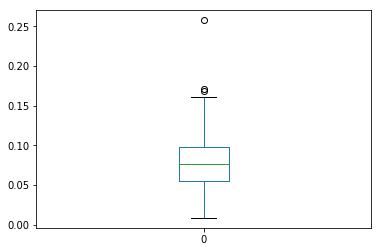

In [43]:
from scipy.stats import variation
# x264-0208-sintel-calda-wasm
# 'x264-1908-bridgefar-wasm'
pathdir = os.path.join(folder, 'x264-1908-caire-wasm')
files = os.listdir(pathdir)
csv_files = [f for f in files if f.endswith('.csv') and f.startswith('x264-results')]
csvs = []
for csv_file in csv_files:
    csv = pd.read_csv(open(os.path.join(pathdir, csv_file), "r"))
    if (len(csv) != 1152):
        print("OOps")
    else:
        csvs.append(csv["elapsedtime"])
    
cv = []
for i in range(1152):
    measures = []
    for j in range(len(csvs)):
        csvj = csvs[j]
        measures.append(csvj[i]) 
    cv.append(variation(measures))
pd.DataFrame(cv).plot.box()
plt.show()
    
#len(csvs)
# simple test